## DecontX simulation + viz of synthetic scRNA-seq data with contamination

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import dirichlet, multinomial
from sklearn.decomposition import PCA

# parameters
n_cells = 200
n_genes = 100
n_clusters = 3
np.random.seed(1)

Native cluster-specific expression profiles (π_k)

In [ ]:
pi_clusters = np.array([dirichlet(alpha=np.ones(n_genes)) for _ in range(n_clusters)])
pi_clusters[:, :5] # genes 0-4

array([[0.03481441, 0.00263727, 0.00370753, 0.02816621, 0.01510847],
       [0.00207516, 0.00577341, 0.01850182, 0.00898255, 0.00615885],
       [0.01036351, 0.02508638, 0.01129835, 0.00349209, 0.00423008]])

Assign cells to clusters, set contamination fractions (ϕ_n), cluster weights w

In [10]:
cell_clusters = np.random.choice(n_clusters, size=n_cells)
phi = np.random.uniform(0, 0.3, n_cells)
cluster_sizes = np.bincount(cell_clusters)
w = cluster_sizes / cluster_sizes.sum()

In [11]:
Y = np.zeros((n_cells, n_genes))
S_true = np.zeros_like(Y)
S_true

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(200, 100))

In [12]:
for n in range(n_cells):
    c = cell_clusters[n]
    # Contamination mixture: weighted sum of other clusters
    eta_n = (w @ pi_clusters - w[c] * pi_clusters[c]) / (1 - w[c])
    # Mixture of native and contaminant expression
    theta_n = (1 - phi[n]) * pi_clusters[c] + phi[n] * eta_n
    total_counts = np.random.poisson(1000)  # sequencing depth
    Y[n, :] = multinomial(total_counts, theta_n)
    S_true[n, :] = multinomial(total_counts, pi_clusters[c])  # true, uncontaminated

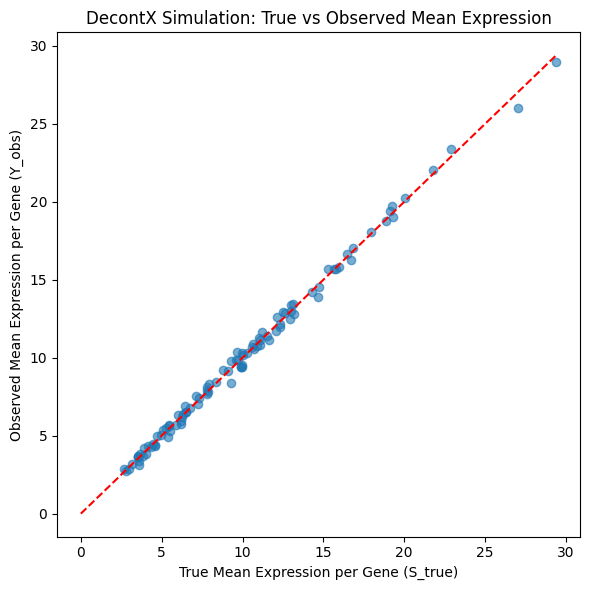

In [13]:
# Visualization 1: Mean gene expression
mean_true = S_true.mean(axis=0)
mean_obs = Y.mean(axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(mean_true, mean_obs, alpha=0.6)
plt.xlabel("True Mean Expression per Gene (S_true)")
plt.ylabel("Observed Mean Expression per Gene (Y_obs)")
plt.title("DecontX Simulation: True vs Observed Mean Expression")
plt.plot([0, max(mean_true)], [0, max(mean_true)], 'r--')
plt.tight_layout()
plt.show()


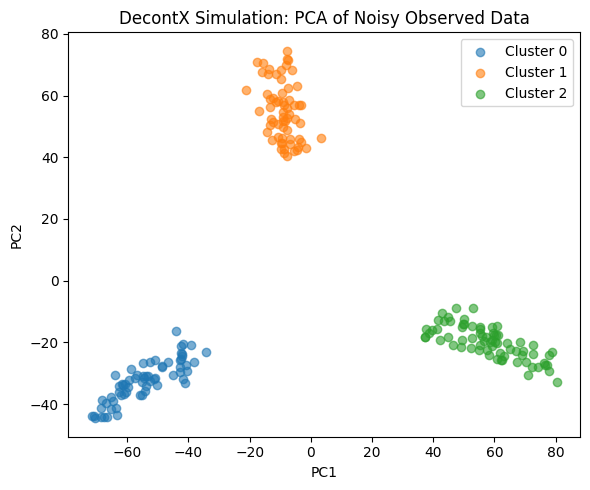

In [14]:
# Visualization 2: PCA of observed (noisy) data
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(Y)

plt.figure(figsize=(6, 5))
for c in range(n_clusters):
    mask = cell_clusters == c
    plt.scatter(pca_coords[mask, 0], pca_coords[mask, 1],
                label=f"Cluster {c}", alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DecontX Simulation: PCA of Noisy Observed Data")
plt.legend()
plt.tight_layout()
plt.show()

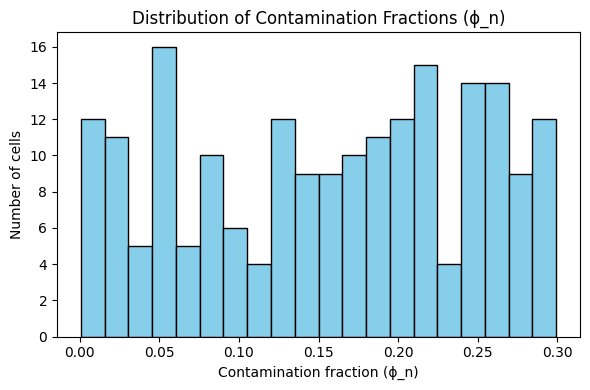

In [15]:
# Visualization 3: Contamination fraction distribution
plt.figure(figsize=(6, 4))
plt.hist(phi, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Contamination fraction (ϕ_n)")
plt.ylabel("Number of cells")
plt.title("Distribution of Contamination Fractions (ϕ_n)")
plt.tight_layout()
plt.show()

In [16]:
synthetic_df = pd.DataFrame(Y, columns=[f"Gene_{g}" for g in range(n_genes)])
synthetic_df["Cluster"] = cell_clusters
synthetic_df["Phi"] = phi
synthetic_df.to_csv("decontx_simulated_data.csv", index=False)